# Podcast Reviews
[Dataset Link](https://www.kaggle.com/datasets/thoughtvector/podcastreviews/versions/28?resource=download)

2 million podcast reviews on 100k podcasts, updated monthly.

# Introduction

## Context
You are an experienced process engineer with a corporate background. Your day-to-day is automating tasks, conducting business results analysis at your company, but now you wish to branch out and build your own brand through podcasting. You believe that your business experience and automation acumen are sufficient enough to build a following, but you will need to perform thorough research on what's popular and highly rated in the podcast market to get the most out of this endeavor.

## Summary
We identified two podcast categories of interest: `business` and `technology` and concluded the following:
* Business podcasts are rated higher on average;
* Business podcasts have more revies on average;
* Both podcast categories have a statistically significant weak negative correlation between ratings and review counts;
* Both podcast categories have a large proportion of 1-review podcasts, the large majority of which have 5-star ratings;
* We've chosen `business` podcasts for subcategory analysis - on average, `marketing` podcasts are rated the highest, while `investment` podcasts are rated the lowest.

## The Questions
### Hypothesis testing & Confidence intervals
1. Is there a significant difference in average ratings between "business" and "technology" podcasts?
2. Is there a significant difference in average amount of reviews per podcast between "business" and "technology" podcasts?
3. Is there a relationship between the number of listener reviews and the average rating within the "business" and "technology" podcast categories?
4. For our chosen "better" category, is there any specific subcategory that receives higher ratings?

With these questions in mind, let's set up the Notebook and prepare the dataset.

# Data Preparation

## Imports & Configuration

In [1]:
# Core Modules, Helper Functions & Database connection
import numpy as np
import pandas as pd
import sqlite3 as sql
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from IPython.display import Image

from utils import database_tables, table_schema, table_head, check_null_values, check_duplicates, corr_ci

conn = sql.connect('archive/database.sqlite')

In [2]:
# Suppress deprecation warnings
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
# Charts' Color Palette
color_palette = sns.color_palette("colorblind")
sns.set_style("whitegrid", {'axes.grid' : False})

In [4]:
# Database tables
tables = database_tables(conn)
print("The database contains the following tables:")
for table in tables:
    print(table)

The database contains the following tables:
runs
podcasts
categories
reviews


## Data Formatting & Cleaning

## Schema & Datatypes

Let's look at each of the tables' schemas and whether it suits the data.

In [5]:
# Schema for database tables
for table in tables:
    table_schema(conn, table)
    table_head(conn, table)

Schema for table runs:
(0, 'run_at', 'TEXT', 1, None, 0)
(1, 'max_rowid', 'INTEGER', 1, None, 0)
(2, 'reviews_added', 'INTEGER', 1, None, 0)


Head of table runs:
           run_at  max_rowid  reviews_added
0  2021-05-10 ...    3266481        1215223
1  2021-06-06 ...    3300773          13139
2  2021-07-02 ...    3329699          11561
3  2021-08-01 ...    3360315          11855
4  2021-09-02 ...    3390165          11714


Schema for table podcasts:
(0, 'podcast_id', 'TEXT', 0, None, 1)
(1, 'itunes_id', 'INTEGER', 1, None, 0)
(2, 'slug', 'TEXT', 1, None, 0)
(3, 'itunes_url', 'TEXT', 1, None, 0)
(4, 'title', 'TEXT', 1, None, 0)


Head of table podcasts:
       podcast_id   itunes_id            slug      itunes_url           title
0  a00018b54eb...  1313466221  scaling-global  https://pod...  Scaling Global
1  a00043d34e7...   158973461  cornerstone...  https://pod...  Cornerstone...
2  a0004b1ef44...   139076942  mystery-dan...  https://pod...  Mystery: Da...
3  a00071f9aaa...  133250

The `runs` table might not be useful for us as it includes the information how many reviews were added to the database on a specific time.

The type of the `created-at` column in table `reviews` seems to be of ISO 8601 format with a timezone offset. It is best to leave it at `TEXT` data type. Other columns and their naming looks good!

## Missing values

In [6]:
for table in tables:
    check_null_values(conn, table_name=table)

No rows with null values found for table runs.
No rows with null values found for table podcasts.
No rows with null values found for table categories.
No rows with null values found for table reviews.


No missing values in all four tables!

## Duplicate values
Before we conduct EDA, let's confirm that the `podcasts` and `categories` tables do not contain any repeating values in the `podcast_id` column.

In [7]:
check_duplicates(conn, table_name='podcasts', column_name='podcast_id')
check_duplicates(conn, table_name='categories', column_name='podcast_id')

No duplicate values found in table podcasts column podcast_id
65569 duplicate values found in table categories column podcast_id:
Value: a00043d34e734b09246d17dc5d56f63c, Count: 2
Value: a0004b1ef445af9dc84dad1e7821b1e3, Count: 2
Value: a00071f9aaae9ac725c3a586701abf4d, Count: 2
Value: a000aa69852b276565c4f5eb9cdd999b, Count: 2
Value: a000b6538cca860a11a94607c13e9595, Count: 2
Value: a0010b283ba17d282c7bb1f9709f0ac3, Count: 2
Value: a0013c50c1e6b24266fdeb10eed6eea7, Count: 3
Value: a0015a878cd03b4d6abb92ea3ce55281, Count: 2
Value: a0018e6d29024e0b70503446a007b933, Count: 2
Value: a0019a55cdf2deca6b7b33ea00482b57, Count: 4
...


The `podcasts` table contains no duplicates! However, the `categories` table might include multiple category rows for the same `podcast_id`; We will keep that in mind as we conduct EDA.

# Data Analysis

## Exploration

Before getting into in-depth analysis and visualization, let's have a look at the contents of some categorical variables and the trends within the numerical variables.

### Overview of categories & average ratings

In [8]:
query = """
    SELECT
        category,
        COUNT(*) AS category_count
    FROM
        categories
    GROUP BY
        category
    ORDER BY
        category_count DESC;
"""
df_category_counts = pd.read_sql_query(query, conn)
print(f"There are a total of {len(df_category_counts)} unique categories!")

There are a total of 110 unique categories!


Not good, we have too many categories at the moment; Fortunately, if the podcast has a specific subcategory, it is separated from the main category by a hyphen '-'. Let's retrieve the main category first; We will use the subcategories later.

In [9]:
query = """
    SELECT
        CASE
            WHEN INSTR(category, '-') > 0 THEN SUBSTR(category, 1, INSTR(category, '-') - 1)
            WHEN category IN ('christianity', 'judaism', 'islam', 'buddhism', 'hinduism') THEN 'religion'
            ELSE category
        END AS category_main,
        COUNT(DISTINCT podcast_id) as podcast_count
    FROM
        categories
    GROUP BY
        category_main
    ORDER BY
        COUNT(*) DESC;
"""
df_main_category_counts = pd.read_sql_query(query, conn)
print(f"We have a total of {len(df_main_category_counts)} main categories.")

We have a total of 20 main categories.


Much better, we narrowed it down to 20 categories. Let's do some summary statistics for each of these categories & then visualize it.

In [10]:
query = """
    SELECT
        CASE
            WHEN INSTR(c.category, '-') > 0 THEN SUBSTR(c.category, 1, INSTR(c.category, '-') - 1)
            WHEN c.category IN ('christianity', 'judaism', 'islam', 'buddhism', 'hinduism') THEN 'religion'
            ELSE c.category
        END AS category_main,
        COUNT(DISTINCT c.podcast_id) total_podcasts,
        AVG(r.rating) AS mean_rating,
        COUNT(r.podcast_id) AS total_ratings,
        COUNT(r.podcast_id) / COUNT(DISTINCT r.podcast_id) AS avg_ratings_podcast
    FROM
        categories AS c
    LEFT JOIN reviews r ON c.podcast_id = r.podcast_id
    GROUP BY
        category_main
    ORDER BY
        total_podcasts DESC;
"""
df = pd.read_sql_query(query, conn)
df.head()

,category_main,total_podcasts,mean_rating,total_ratings,avg_ratings_podcast
0,society,19441,4.573489,661784,34
1,education,13005,4.827938,359999,27
2,business,12931,4.851494,435746,33
3,comedy,12803,4.636115,413180,32
4,religion,12609,4.827991,242853,19


We summarized each category successfully! Let's visualize.

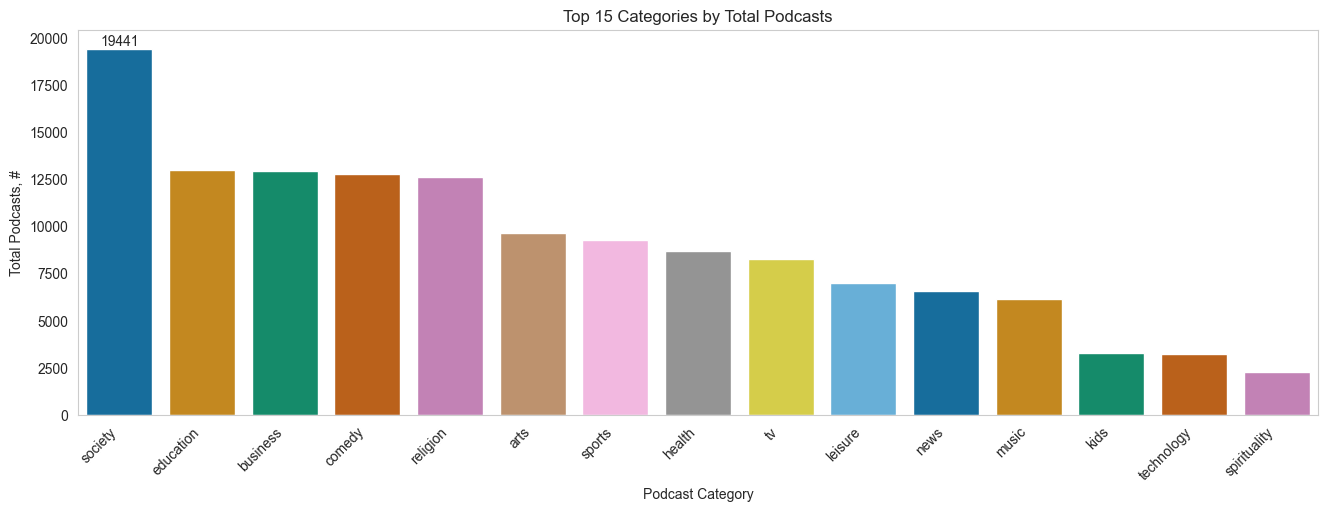

In [11]:
plt.figure(figsize=(16, 5))
ax = sns.barplot(data=df[:15], x='category_main', y='total_podcasts', palette=color_palette)
ax.bar_label(ax.containers[0])
plt.xlabel('Podcast Category')
plt.ylabel('Total Podcasts, #')
plt.xticks(rotation=45, ha='right')
plt.title('Top 15 Categories by Total Podcasts');

The `business` and `technology` match our profile the best; Fortunately, both of these categories have a good amount of podcasts.

From here on, our analysis will focus on identifying which of the two categories is the better choice for starting our podcasting endeavor. All of our statistical analysis will assume a **confidence level of 95%**

In [12]:
confidence_level = 0.95

## Mean Rating of Business and Technology podcasts
The rating is a good indicator of the general quality of the podcasts in the category. High ratings may indicate that the podcast is well-received by its audience. It may indicate that the content is informative, entertaining, and aligns well with the expectations of the target audience. Podcasts with consistently high ratings are likely to attract a larger audience and potentially generate more revenue through advertising or sponsorships. Low ratings may indicate a poor growth market, i.e. the category or niche is not attractive to listeners. We will compare the average ratings of the two categories to find which of the two is more successful in this regard.

**Question**: Is there a significant difference in average ratings between "business" and "technology" podcasts?
* *Null Hypothesis (H0)*: There is no difference in average ratings between "business" and "technology" podcasts.
* *Alternative Hypothesis (H1)*: There is a difference in average ratings between "business" and "technology" podcasts.

In [13]:
query = """
    WITH category_rating AS (
        SELECT
            CASE
                WHEN INSTR(c.category, '-') > 0 THEN SUBSTR(c.category, 1, INSTR(c.category, '-') - 1)
                WHEN c.category IN ('christianity', 'judaism', 'islam', 'buddhism', 'hinduism') THEN 'religion'
                ELSE c.category
            END AS category_main,
            r.rating
        FROM
            categories AS c
        LEFT JOIN reviews r ON c.podcast_id = r.podcast_id
    )
    SELECT
        category_main AS category,
        rating
    FROM
        category_rating
    WHERE
        category_main IN ('business', 'technology');
"""
ratings = pd.read_sql_query(query, conn).dropna()

In [14]:
ratings_business = ratings.loc[ratings['category'] == 'business', 'rating']
ratings_technology = ratings.loc[ratings['category'] == 'technology', 'rating']

In [15]:
sd_business = np.std(ratings_business, ddof = 1)
sd_technology = np.std(ratings_technology, ddof = 1)
print("The standard deviation of Technology podcasts` ratings is {:.3f}".format(sd_technology))
print("The standard deviation of Business podcasts` ratings is {:.3f}".format(sd_business))

The standard deviation of Technology podcasts` ratings is 1.142
The standard deviation of Business podcasts` ratings is 0.675


The standard deviations differ largely, at a ratio of 1.69. The pooled approach is possible, however, we will confirm our findings by including the **Welch's t-test** as well.

### The pooled t-test

In [16]:
# Sample sizes
n_business = ratings_business.shape[0]
n_technology = ratings_technology.shape[0]

# Pooled standard deviation
sp = np.sqrt(
    ((n_business - 1) * sd_business ** 2 + (n_technology - 1) * sd_technology ** 2) / 
    (n_business + n_technology - 2))

# Pooled standard error
pooled_se = sp * np.sqrt(1 / n_business + 1 / n_technology)

# Degrees of freedom & Mean difference
dof = n_business + n_technology - 2
mean_diff = np.mean(ratings_business) - np.mean(ratings_technology)

# t-statistic
t_stat = mean_diff / pooled_se

# p-value
one_tailed_prob = 1 - stats.t.cdf(t_stat, dof)
two_tailed_prob = one_tailed_prob * 2

print("The t-statistic is: {:.3f}".format(t_stat))
print("The p-value is: {:.5f}".format(two_tailed_prob))

The t-statistic is: 90.948
The p-value is: 0.00000


### The Welch's t-test

In [17]:
t_stat, p_value = stats.ttest_ind(ratings_business, ratings_technology, equal_var=False)
print("The t-statistic is: {:.3f}".format(t_stat))
print("The p-value is: {:.5f}".format(p_value))

The t-statistic is: 60.462
The p-value is: 0.00000


### Confidence Intervals for Mean Ratings (Unpooled)
For difference in average mean ratings, we will assume that standard deviations are not equal.

In [18]:
# Confidence intervals for each category
ci_business = sm.stats.DescrStatsW(ratings_business)
ci_technology = sm.stats.DescrStatsW(ratings_technology)

# Degrees of freedom
numerator = (sd_business**2 / n_business + sd_technology**2 / n_technology)**2
denominator = (sd_business**2 / n_business)**2 / (n_business - 1) + (sd_technology**2 / n_technology)**2 / (n_technology - 1)
dof = numerator / denominator

# t-statistic
t_stat = stats.t.ppf((1 + confidence_level) / 2, dof)

# Standard error
se_diff = np.sqrt((sd_business**2 / n_business) + (sd_technology**2 / n_technology))

# Confidence interval bounds
lcb = mean_diff - (t_stat * se_diff)
ucb = mean_diff + (t_stat * se_diff)
ci_business = ci_business.zconfint_mean()
ci_technology = ci_technology.zconfint_mean()

print("Business podcasts, on average, are rated from {:.3f} to {:.3f}".format(ci_business[0], ci_business[1]))
print("Technology podcasts, on average, are rated from {:.3f} to {:.3f}".format(ci_technology[0], ci_technology[1]))
print("The difference between the ratings of the two groups is from {:.3f} to {:.3f}".format(lcb, ucb))

Business podcasts, on average, are rated from 4.849 to 4.853
Technology podcasts, on average, are rated from 4.519 to 4.540
The difference between the ratings of the two groups is from 0.311 to 0.332


### Summary
With 95% confidence, we can conclude the following:
* With a p-value of 0, we have sufficient evidence to conclude that the average rating of business and technology podcasts differs significantly.
* Business podcasts, on average, are rated at **4.85**
* Technology podcasts, on average, are rated from **4.52** to **4.54**
* The difference between the ratings of the two categories is between **0.31** and **0.332**

To visually confirm our findings, let's chart the distribution of ranking for each category.

In [19]:
business_counts = np.bincount(ratings_business, minlength=6)[1:6]
technology_counts = np.bincount(ratings_technology, minlength=6)[1:6]

business_proportions = business_counts / len(ratings_business) * 100
technology_proportions = technology_counts / len(ratings_technology) * 100

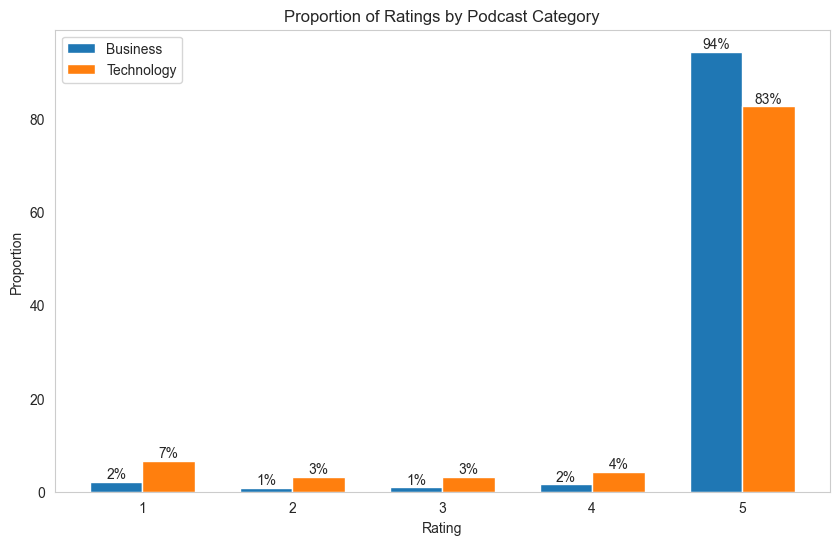

In [20]:
plt.figure(figsize=(10, 6))
bar_width = 0.35
x = np.arange(1, 6)
bars1 = plt.bar(x - bar_width/2, business_proportions, bar_width, label='Business')
bars2 = plt.bar(x + bar_width/2, technology_proportions, bar_width, label='Technology')

# Add percentage labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height, '%.0f' % height + '%', ha='center', va='bottom')
        
plt.xlabel('Rating')
plt.ylabel('Proportion')
plt.title('Proportion of Ratings by Podcast Category')
plt.xticks(x)
plt.legend();

The podcasts in the `technology` category are more spread out to the 1-4 range. The smaller proportion in the 5 rating category brings the mean rating down.

## Mean Review Counts of Business and Technology podcasts
An important facet of the podcasts' success is the listener engagement; A category might not have the biggest offering of podcasts to listen to, but the listener base might be large for the few that are available. We will explore which podcast category gets the most reviews on average.

**Question**: Is there a significant difference in average review counts between "business" and "technology" podcasts?
* *Null Hypothesis (H0)*: There is no difference in average review counts between "business" and "technology" podcasts.
* *Alternative Hypothesis (H1)*: There is a difference in average review counts between "business" and "technology" podcasts.

In [21]:
query = """
    WITH podcast_reviews AS (
        SELECT
            CASE
                WHEN INSTR(c.category, '-') > 0 THEN SUBSTR(c.category, 1, INSTR(c.category, '-') - 1)
                WHEN c.category IN ('christianity', 'judaism', 'islam', 'buddhism', 'hinduism') THEN 'religion'
                ELSE c.category
            END AS category,
            c.podcast_id,
            COUNT(r.podcast_id) AS review_count
        FROM categories AS c
        LEFT JOIN reviews AS r ON c.podcast_id = r.podcast_id
        GROUP BY
            category,
            c.podcast_id
    )
    SELECT
        category,
        review_count
    FROM
        podcast_reviews
    WHERE
        category IN ('business', 'technology');
"""
reviews = pd.read_sql_query(query, conn).dropna()

In [22]:
reviews_business = reviews.loc[reviews['category'] == 'business', 'review_count']
reviews_technology = reviews.loc[reviews['category'] == 'technology', 'review_count']

In [23]:
sd_business = np.std(reviews_business, ddof = 1)
sd_technology = np.std(reviews_technology, ddof = 1)
print("The standard deviation of Technology podcasts` review counts is {:.3f}".format(sd_technology))
print("The standard deviation of Business podcasts` review counts is {:.3f}".format(sd_business))

The standard deviation of Technology podcasts` review counts is 66.088
The standard deviation of Business podcasts` review counts is 72.486


The standard deviations differ only slightly, only at a ratio of **1.1**. We will use the pooled approach & double-check with the Welch's t-test for the non-pooled alternative.

### The pooled t-test

In [24]:
t_stat, p_value = sm.stats.ztest(reviews_business, reviews_technology)
print("The t-statistic is: {:.3f}".format(t_stat))
print("The p-value is: {:.5f}".format(p_value))

The t-statistic is: 3.428
The p-value is: 0.00061


### The Welch's t-test

In [25]:
t_stat, p_value = stats.ttest_ind(reviews_business, reviews_technology, equal_var=False)
print("The t-statistic is: {:.3f}".format(t_stat))
print("The p-value is: {:.5f}".format(p_value))

The t-statistic is: 3.673
The p-value is: 0.00024


### Confidence Intervals for Mean Ratings (Pooled)
For difference in average review counts, we will assume that standard deviations are equal (1.1 ratio).

In [26]:
# Confidence intervals
ci_business = sm.stats.DescrStatsW(reviews_business)
ci_technology = sm.stats.DescrStatsW(reviews_technology)

# Means
mean_business = np.mean(reviews_business)
mean_technology = np.mean(reviews_technology)

# Standard deviations
std_business = np.std(reviews_business, ddof=1)
std_technology = np.std(reviews_technology, ddof=1)

# Sample sizes
n_business = len(reviews_business)
n_technology = len(reviews_technology)

# Degrees of freedom (Pooled approach)
dof = n_business + n_technology - 2

# Pooled standard deviation
pooled_std = np.sqrt(((n_business - 1) * std_business**2 + (n_technology - 1) * std_technology**2) / dof)

# t-value
t_stat = stats.t.ppf((1 + confidence_level) / 2, dof)

# Pooled standard error
se_difference_pooled = pooled_std * np.sqrt(1 / n_business + 1 / n_technology)

# Confidence interval bounds
lcb = (mean_business - mean_technology) - (t_stat * se_difference_pooled)
ucb = (mean_business - mean_technology) + (t_stat * se_difference_pooled)
ci_business = ci_business.zconfint_mean()
ci_technology = ci_technology.zconfint_mean()

print("Business podcasts, on average, get from {:.1f} to {:.1f} reviews".format(ci_business[0], ci_business[1]))
print("Technology podcasts, on average, get from {:.1f} to {:.1f} reviews".format(ci_technology[0], ci_technology[1]))
print("The difference between the average review counts of the two groups is from {:.1f} to {:.1f} reviews".format(lcb, ucb))

Business podcasts, on average, get from 18.5 to 20.4 reviews
Technology podcasts, on average, get from 12.5 to 17.1 reviews
The difference between the average review counts of the two groups is from 2.0 to 7.3 reviews


### Summary
With 95% confidence, we can conclude the following:
* With a p-value of 0.00061, we have sufficient evidence to conclude that the average review count of business and technology podcasts differs significantly.
* Business podcasts, on average, get from **19** to **20** reviews
* Technology podcasts, on average, get from **13** to **17** reviews
* The difference between the review counts of the two categories is between **2** and **7**

## Relationship between Ratings & Review Counts
To finalize our hypothesis testing, let's explore the relationship between average rating & review counts. We will calculate the correlation coefficient and p-value for both business & technology podcasts.

**Question**: Is there a relationship between the number of listener reviews and the average rating within the "business" and "technology" podcast categories?
* Null Hypothesis (H0): There is no correlation between the number of listener reviews and the average rating within "business" and "technology" podcast categories.
* Alternative Hypothesis (H1): There is a correlation between the number of listener reviews and the average rating within "business" and "technology" podcast categories.

In [27]:
query = """
    WITH podcast_reviews_ratings AS (
        SELECT
            CASE
                WHEN INSTR(c.category, '-') > 0 THEN SUBSTR(c.category, 1, INSTR(c.category, '-') - 1)
                WHEN c.category IN ('christianity', 'judaism', 'islam', 'buddhism', 'hinduism') THEN 'religion'
                ELSE c.category
            END AS category,
            c.podcast_id,
            COUNT(r.podcast_id) AS review_count,
            AVG(r.rating) AS mean_rating
        FROM categories AS c
        LEFT JOIN reviews AS r ON c.podcast_id = r.podcast_id
        GROUP BY
            category,
            c.podcast_id
    )
    SELECT
        category,
        review_count,
        mean_rating
    FROM
        podcast_reviews_ratings
    WHERE
        category IN ('business', 'technology');
"""
reviews_ratings = pd.read_sql_query(query, conn)

In [28]:
reviews_ratings_business = reviews_ratings.loc[reviews_ratings['category'] == 'business', ['review_count', 'mean_rating']]
reviews_ratings_technology = reviews_ratings.loc[reviews_ratings['category'] == 'technology', ['review_count', 'mean_rating']]

In [29]:
print("Business category:")
corr_ci(reviews_ratings_business, 'review_count', 'mean_rating')
print("\n")

print("Technology category:")
corr_ci(reviews_ratings_technology, 'review_count', 'mean_rating')

Business category:
Correlation coefficient: -0.03
95% confidence interval: [0.00000, -0.06189]
p-value: 0.0000


Technology category:
Correlation coefficient: -0.07
95% confidence interval: [0.00000, -0.14345]
p-value: 0.0000


### Summary
With 95% confidence, we can conclude the following:
* With a p-value of 0 for both categories, we have sufficient evidence to conclude that the negative correlation for both categories is statistically significant.
* Business podcasts have a weak negative correlation between average ratings & review counts in range from **0** to **-0.06**
* Technology podcasts have a slightly stronger negative correlation between average ratings & review counts in range from **0** to **-0.143**

We can derive two theories:
* Naturally, as reviews increase, the average rating shifts away from the perfect score of 5;
* There might be more cases where podcasts have 5-star ratings and only a few reviews, compared to 1-star ratings with only a few reviews.

Let's investigate the second theory by doing some analysis on podcasts with 1 review.

In [30]:
business_one_review = reviews_ratings_business[reviews_ratings_business['review_count'] == 1]
technology_one_review = reviews_ratings_technology[reviews_ratings_technology['review_count'] == 1]
prop_business = round(len(business_one_review) / len(reviews_ratings_business) * 100, 0)
prop_technology = round(len(technology_one_review) / len(reviews_ratings_technology) * 100, 0)

print(f"{len(business_one_review)} ({prop_business}%) business podcasts have only 1 review.")
print(f"{len(technology_one_review)} ({prop_technology}%) technology podcasts have only 1 review.")

6146 (27.0%) business podcasts have only 1 review.
1055 (33.0%) technology podcasts have only 1 review.


A third of technology podcasts have only 1 review! Let's see if our theory of 1-review-perfect-score is true.

In [31]:
business_agg = business_one_review.groupby('mean_rating')['review_count'].count()
technology_agg = technology_one_review.groupby('mean_rating')['review_count'].count()

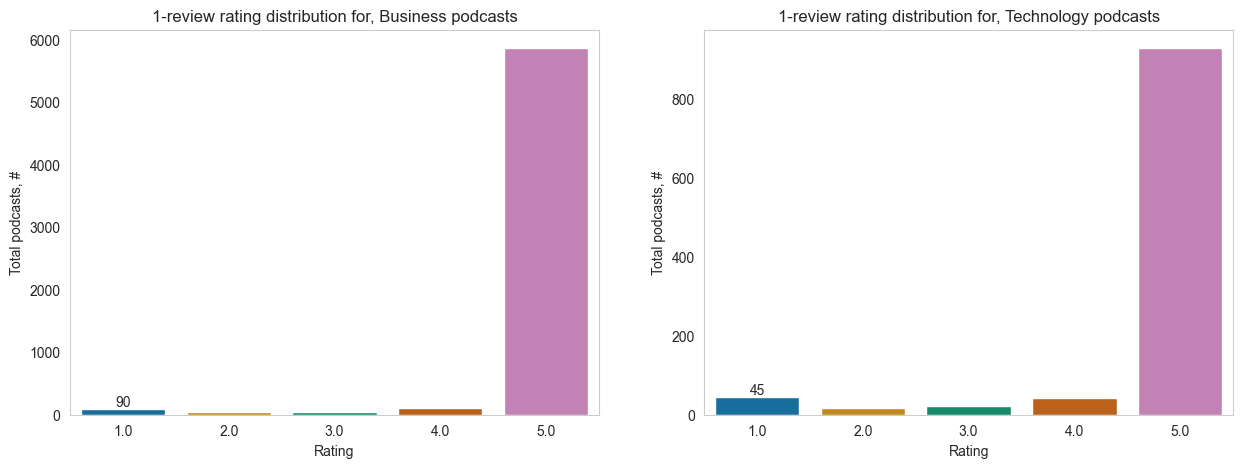

In [32]:
categories = ['Business', 'Technology']
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i, category in enumerate([business_agg, technology_agg]):
    ax = sns.barplot(x=category.index, y=category.values, ax=axes[i], palette=color_palette)
    ax.bar_label(ax.containers[0])
    axes[i].set_title(f"1-review rating distribution for, {categories[i]} podcasts")
    axes[i].set_xlabel('Rating')
    axes[i].set_ylabel('Total podcasts, #');

In both cases, we see that a very large portion of 1-review podcasts have a 5-point rating. The proportions are very similar among both categories, but technology podcasts have a larger proportion of 1-review podcasts overall; This finding explains the slightly larger negative correlation coefficient for technology podcasts.

## The most successful subcategories
All of our tests have indicated `business` podcasts to be the winner - they have a higher average podcast rating, more reviews & are slightly less prone to the influence 5-star rated 1-review podcasts. To finalize our analysis, let's pick a niche within the business category that is the most successful in terms of rating and popularity.

In [33]:
query = """
    SELECT
        CASE
            WHEN INSTR(c.category, '-') > 0 THEN SUBSTR(c.category, 1, INSTR(c.category, '-') - 1)
            WHEN c.category IN ('christianity', 'judaism', 'islam', 'buddhism', 'hinduism') THEN 'religion'
            ELSE c.category
        END AS category_main,
        CASE
            WHEN INSTR(c.category, '-') > 0 THEN SUBSTR(c.category, INSTR(c.category, '-') + 1)
            ELSE c.category
        END AS subcategory,
        COUNT(DISTINCT c.podcast_id) total_podcasts,
        AVG(r.rating) AS mean_rating
    FROM
        categories AS c
    LEFT JOIN reviews r ON c.podcast_id = r.podcast_id
    GROUP BY
        category_main, subcategory
    HAVING
        category_main = 'business'
    ORDER BY
        total_podcasts DESC;
"""
df = pd.read_sql_query(query, conn)

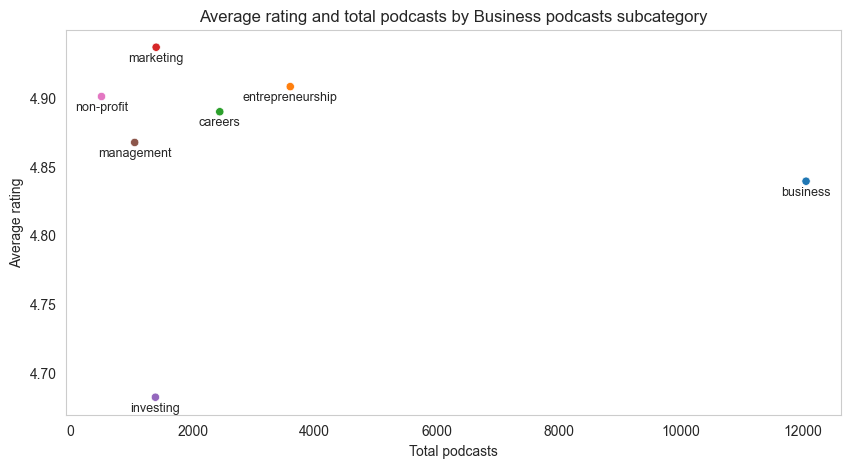

In [34]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='total_podcasts', y='mean_rating', hue='subcategory', legend=False)
for i, row in df.iterrows():
    plt.text(row['total_podcasts'], row['mean_rating']-0.01, row['subcategory'], fontsize=9, ha='center')
plt.xlabel("Total podcasts")
plt.ylabel("Average rating")
plt.title("Average rating and total podcasts by Business podcasts subcategory")
plt.show();

A large chunk of podcasts do not have a concrete subcategory - a lot of them are grouped into the generic `business` category. Regardless, here are some observations:
* `investing` seems to score the lowest of the subcategories with a decent podcast quantity
* `marketing` has the largest rating of the subcategories with a respectable sub-2000 podcast quantity
* `non-profit` is the least populated business subcategory, with a great average rating

# Additional visuals through Microsoft Power BI
As part of EDA practice with BI tools, here are some visuals that capture the general trends among podcasts.

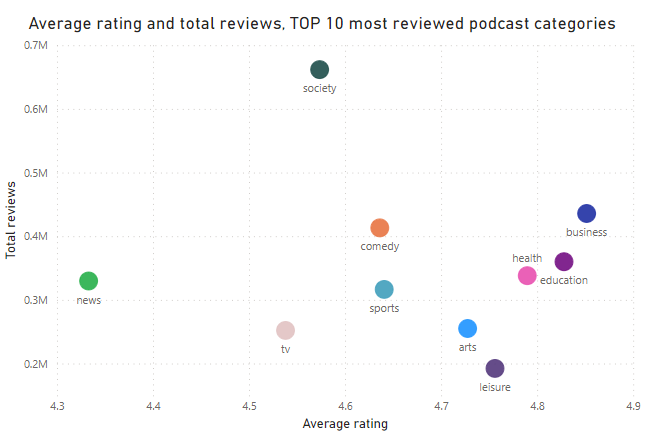

In [35]:
Image(filename='media/1.png')

The scatterplot gives us a good visual representation of which podcasts have received the most reviews & stayed within high ratings. `Business` podcasts seem to strike a good middle ground between respectable review counts & a stellar average rating.

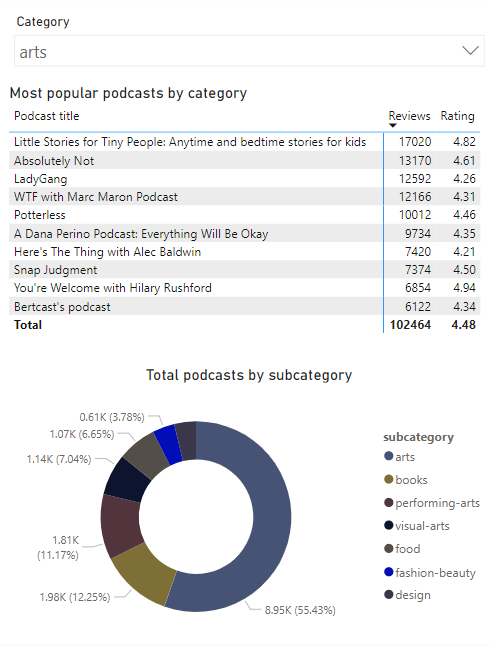

In [36]:
Image(filename='media/2.png')

The second visualization is interactive - it lets the user select a category & see the following:
* The 10 most popular podcasts for the category;
* The distribution of podcast subcategories that fall within the selected category.

# Conclusion
We've identified two podcast categories that best suit our interests and experience - `business` and `technology`; We've pitted them together and used hypothesis testing to identify which of the categories is the more appealing options for us to start our own podcasting journey.

## Findings
As mentioned previously, the findings assumed a 95% confidence level.

### Mean Rating
* The average rating of business and technology podcasts differs significantly.
* Business podcasts, on average, are rated at **4.85**
* Technology podcasts, on average, are rated from **4.52** to **4.54**
* The difference between the ratings of the two categories is between **0.31** and **0.33**

### Mean Review counts
* The average review count of business and technology podcasts differs significantly.
* Business podcasts, on average, get from **19** to **20** reviews
* Technology podcasts, on average, get from **13** to **17** reviews
* The difference between the review counts of the two categories is between **2** and **7**

### Relationship between rating and review counts
* Both `business` and `technology` categories' mean ratings and review counts follow a statistically significant weak negative correlation.
* Business podcasts have the aforementioned correlation coefficient ranging from **0** to **-0.06**
* Technology podcasts have a slightly stronger negative correlation coefficient ranging from **0** to **-0.143**
* An important consideration to this finding is the significant proportion of 1-review podcasts, which tend to skew the results. 

## Recommendations
With our findings in mind, we'll test the waters in the `business` category. None of the subcategories really match our profile, so we'll invent a subcategory of `business automation` and test that out!

## Considerations and Improvements for Future Studies
### Considerations
1. Entirety of the dataset (all podcasts & their reviews from the selected platform are included)
2. Does the dataset include all major platforms that host podcasts? It seems to have only those that are available on iTunes.

### Improvements for Similar Studies
1. Hypothesis testing excluding 1-review podcasts.
2. Hypothesis testing including temporal data.
3. Review text analysis.